In [2]:
## Importing the dependencies
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from matplotlib.patches import Circle
import io
from IPython.display import Image

In [12]:
# --------------------------------------------------------------------------------------------------------------------------------------------------------

## Define the file paths for the pose model's architecture (protofile) and pre-trained weights (weightsfile).

protofile = r"D:\My Desktop\123\kaggle\open-cv\2\pose\model\\pose_deploy_linevec_faster_4_stages.prototxt"
weightsfile = r"D:\My Desktop\123\kaggle\open-cv\2\pose\model\\pose_iter_160000.caffemodel"

# --------------------------------------------------------------------------------------------------------------------------------------------------------

## Specify the keypoints and their connections to form the pose skeleton 

npoints = 15
pose_parts = [
    [0,1],
    [1, 2],
    [2, 3],
    [3, 4],
    [1, 5],
    [5, 6],
    [6, 7],
    [1, 14],
    [14, 8],
    [8, 9],
    [9, 10],
    [14, 11],
    [11, 12],
    [12, 13],    
]
# --------------------------------------------------------------------------------------------------------------------------------------------------------

# Loading the pretrained model
net = cv2.dnn.readNetFromCaffe(protofile, weightsfile)

#--------------------------------------------------------------------------------------------------------------------------------------------------------

# Load the image using OpenCV

def estimate_pose(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read the image at {image_path}")
        return

    # Store width and height of the original image 
    inwidth = image.shape[1]
    inheight = image.shape[0]

    #creating a blob representation (Use cv2.dnn.blobFromImage to normalize, resize, and organize the image for input to the neural network.)
    netinputSize =  (368,368)
    inputblob = cv2.dnn.blobFromImage(image , 1.0/255,netinputSize, (0,0,0),swapRB = True, crop = False)
    net.setInput(inputblob)

    # Run Inference (forward pass)
    output = net.forward()

    #Calculating the scaling factors
    scaleX = inwidth / output.shape[3]
    scaleY = inheight / output.shape[2]

    points  =[]
    
    # Setting the threshold
    # (If the probability of a keypoint (or any feature) in the generated output is greater than the threshold, 
    # the point is considered valid or detected.)
              
    threshold = 0.01

    # Below, the code iterates over each of the nPoints (number of points or keypoints) in the output.
    # For each keypoint, it extracts the probability map from the output.
    # The shape of output is typically (1, C, H, W), where C is the number of channels (often equal to the number of keypoints), 
    # and H and W are the height and width of the probability maps.
    
    for i in range(npoints):
        # Extracts the probability map for the i-th keypoint.
        probMap = output[0,i, :,:]
        
        #finding global maxima
        minVal , prob , minLoc, point  = cv2.minMaxLoc(probMap)
        x = scaleX * point[0]
        y = scaleY * point[1]

        if prob > threshold:
            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
        else:
            points.append(None)
    #return points 
    
    imPoints = image.copy()
    imSkeleton = image.copy()
    
    imPoints = cv2.cvtColor(imPoints , cv2.COLOR_BGR2RGB)
    imSkeleton = cv2.cvtColor(imSkeleton, cv2.COLOR_BGR2RGB)
    
    # Drawing for circular points on the image
    for i, p in enumerate(points):
        cv2.circle(imPoints, p, 8, (255, 255, 0), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(imPoints, "{}".format(i), p, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, lineType=cv2.LINE_AA)

    # Drawing the skeleton on the image
    for pair in pose_parts:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(imSkeleton, points[partA], points[partB], (255, 255, 0), 2)
            cv2.circle(imSkeleton, points[partA], 8, (255, 0, 0), thickness=-1, lineType=cv2.FILLED)
    
    # Plotting the results
    plt.figure(figsize=(50, 50))

    plt.subplot(121)
    plt.axis("off")
    plt.imshow(imPoints)
    #cv2.imshow('points iamge', imPoints)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    plt.subplot(122)
    plt.axis("off")
    plt.imshow(imSkeleton)
    #cv2.imshow('skeleton' , imSkeleton)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

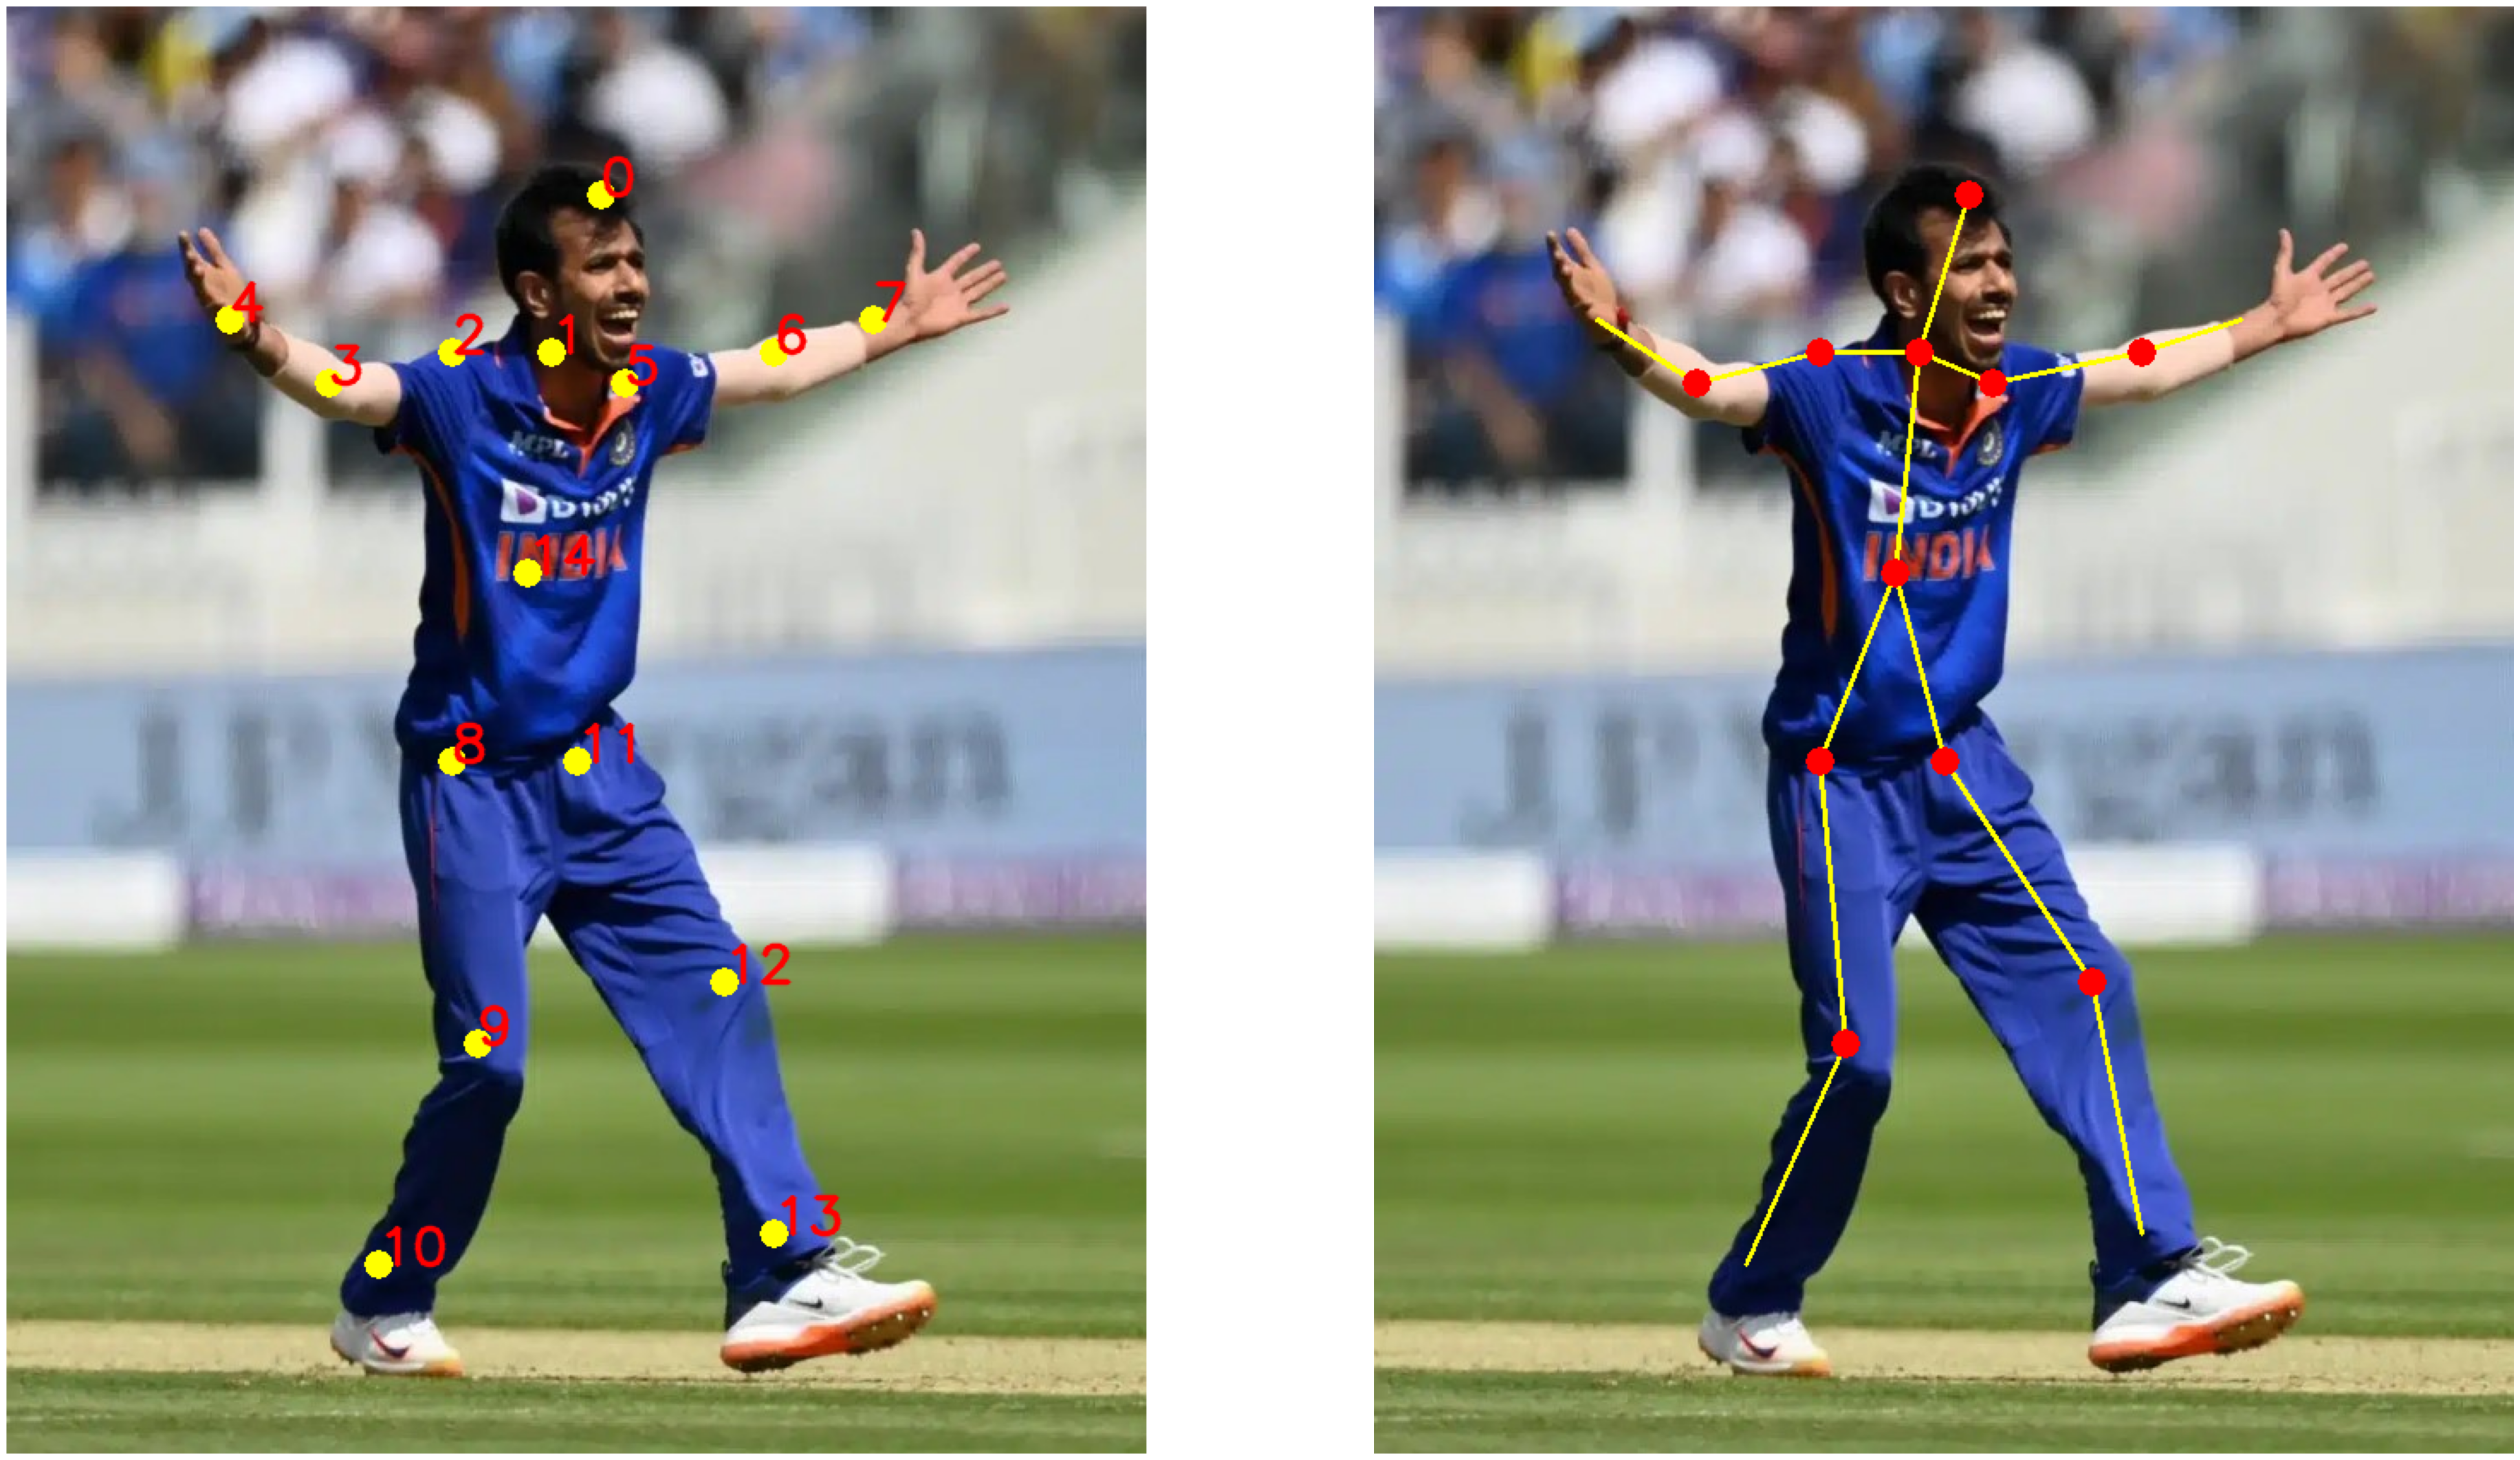

In [13]:
image_path = r"D:\My Desktop\123\kaggle\open-cv\2\pose\\yuzi.jpg"
estimate_pose(image_path)